# Task 1 State Vector simulation of quantum circuits

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt

## 1) Naive simulation using matrix multiplication

### Define gates

In [13]:
def X():
    return np.array([[0, 1], [1, 0]])

def H():
    return np.array([[1, 1], [1, -1]]) / np.sqrt(2)

def CNOT():
    return np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]])

### Matrix multiplication 

In [14]:
def init_state(n):
    return np.array([1] + [0] * (2**n - 1))

def apply_gate(state, gate):
    return np.dot(gate, state)

def simulate(n, gates):
    state = init_state(n)
    # print(state)
    for gate in gates:
        state = apply_gate(state, gate)
        # print(state)

    return state

### Plot the runtime of your code as a function of the number of qubits.

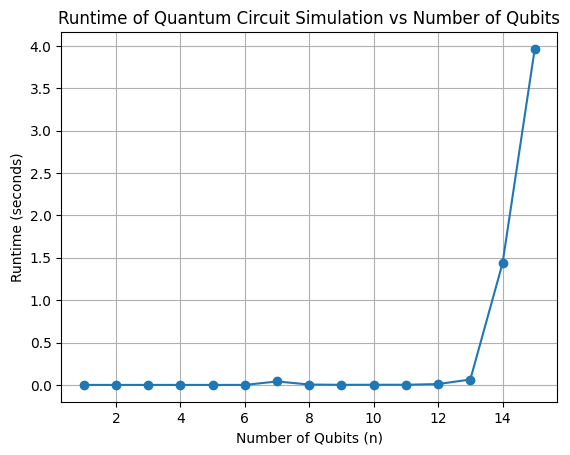

In [15]:
n_qubits = list(range(1, 16)) 
runtimes = []

for n in n_qubits:
    gates = []
    gates.append(np.kron(X(), np.eye(2**(n-1))))  # Apply X to the first qubit
    gates.append(np.kron(H(), np.eye(2**(n-1))))  # Apply H to the first qubit
    if n > 1:
        gates.append(np.kron(np.eye(2**(n-2)), CNOT()))  # Apply CNOT to the last two qubits
    
    start_time = time.time()
    simulate(n, gates)
    end_time = time.time()
    runtimes.append(end_time - start_time)

plt.plot(n_qubits, runtimes, marker='o')
plt.xlabel('Number of Qubits (n)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of Quantum Circuit Simulation vs Number of Qubits')
plt.grid()
plt.show()

### How many qubits can you simulate this way?

I can simulate 15 qubits but when I try to simulate 16 the notebook dies.

## 2) Advanced simulation using tensor multiplication

### Tensor multiplication

In [16]:
def create_n_qubit_zero_state_tensor(n):
    # Create an n-dimensional tensor with shape (2, 2, ..., 2)
    tensor_shape = (2,) * n 
    n_qubit_tensor = np.zeros(tensor_shape)  # Initialize the tensor with zeros
    # Set the first element to 1 to represent |0> state
    n_qubit_tensor[tuple([0] * n)] = 1
    
    return n_qubit_tensor

def tensor_to_vector(tensor):

    return tensor.flatten()

def vector_to_tensor(vector, n):
    tensor_shape = (2,) * n
    
    return vector.reshape(tensor_shape)

def simulate_quantum_circuit(n_qubits):
    # Initial state |00...0⟩
    quantum_state = create_n_qubit_zero_state_tensor(n_qubits)
    # print(tensor_to_vector(quantum_state))

    # Apply X to the first qubit
    quantum_state = np.tensordot(X(), quantum_state.reshape(2, -1), axes=([1], [0])).reshape(-1)
    # print(tensor_to_vector(quantum_state))

    # Apply H to the first qubit
    quantum_state = np.tensordot(H(), quantum_state.reshape(2, -1), axes=([1], [0])).reshape(-1)
    # print(tensor_to_vector(quantum_state))

    # Apply CNOT to qubits 1 and 2 (first qubit as control, second as target)
    if n_qubits > 1:
        quantum_state = np.tensordot(np.kron(np.eye(2**(n_qubits-2)), CNOT()), quantum_state.reshape(2**n_qubits, 1), axes=([1], [0]))
        # print(tensor_to_vector(quantum_state))

    return quantum_state


### Plot the runtime of your code as a function of the number of qubits.

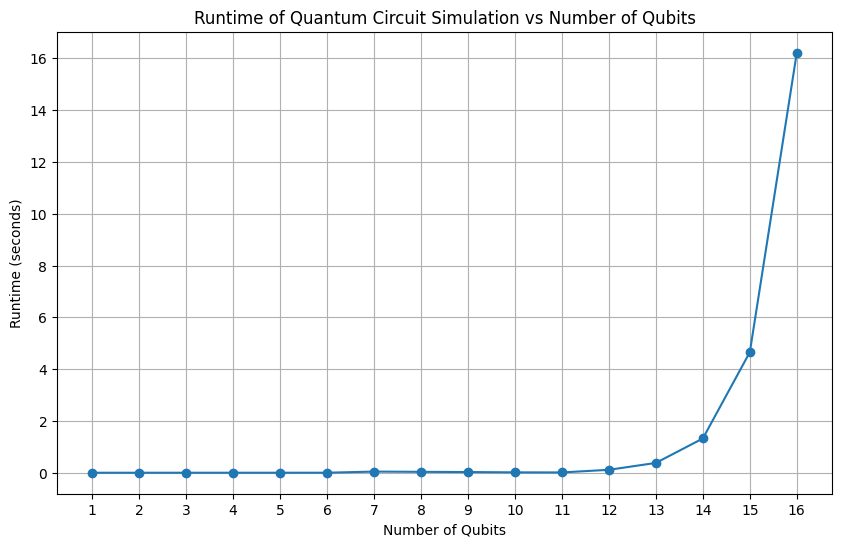

In [17]:
qubit_counts = range(1, 17) 
runtimes = []

for n in qubit_counts:
    start_time = time.time()
    simulate_quantum_circuit(n)
    runtimes.append(time.time() - start_time)

plt.figure(figsize=(10, 6))
plt.plot(qubit_counts, runtimes, marker='o')
plt.title('Runtime of Quantum Circuit Simulation vs Number of Qubits')
plt.xlabel('Number of Qubits')
plt.ylabel('Runtime (seconds)')
plt.xticks(qubit_counts)
plt.grid(True)
plt.show()

### How many qubits can you simulate this way?

I can simulate 16 qubits but when I try to simulate 17 the notebook dies.

### Compare your results to subtask 1).

Using tensor multiplication I can simulate one more qubit than using matrix multiplication.

## 3) Bonus question

### 1. How would you sample from the final states in the state vector or tensor representations? 

In [18]:
def sample_from_n_qubit_state(state):
    # Calculate probabilities
    probabilities = np.abs(state) ** 2
    # Construct cumulative distribution
    cumulative_probabilities = np.cumsum(probabilities)
    r = np.random.rand()
    
    # Sample based on cumulative distribution
    sampled_index = np.searchsorted(cumulative_probabilities, r)
    return sampled_index  # Return the index of the sampled basis state

In [19]:
state_vector = np.array([0,0,0,0,0,0,0,0.70710678,0,0,0,0,0,0,0,-0.70710678])
# Perform sampling
sampled_index = sample_from_n_qubit_state(state_vector)
print(f"Sampled state index: {sampled_index}, State: |{bin(sampled_index)[2:].zfill(n)}>")

Sampled state index: 7, State: |0000000000000111>


In [20]:
quantum_state = np.array([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0])
quantum_state = np.tensordot(H(), quantum_state.reshape(2, -1), axes=([1], [0])).reshape(-1)
quantum_state = np.tensordot(np.kron(np.eye(2**(4-2)), CNOT()), quantum_state.reshape(2**4, 1), axes=([1], [0]))
quantum_state
sampled_index = sample_from_n_qubit_state(quantum_state)
print(f"Sampled state index: {sampled_index}, State: |{bin(sampled_index)[2:].zfill(n)}>")

Sampled state index: 2, State: |0000000000000010>


### 2.	And how about computing exact expectation values in the form <Ψ| Op |Ψ>?

In [21]:
import numpy as np

# Create a random n-qubit operator (Hermitian)
def create_n_qubit_operator(n):
    # Generate a random Hermitian operator
    mat = np.random.randn(2**n, 2**n) + 1j * np.random.randn(2**n, 2**n)
    hermitian_operator = (mat + mat.conj().T) / 2  # Ensure Hermitian
    return hermitian_operator

# Computing the expectation value <Ψ| O |Ψ>
def expectation_value_nqubit(state, operator):
    # Compute O |Ψ⟩
    O_state = operator @ state
    # Compute <Ψ| O |Ψ⟩
    exp_value = np.conj(state).T @ O_state
    return exp_value.real

In [22]:
n = 2
state_vector = np.array([ 0.70710678, 0, 0, -0.70710678])
operator_O = create_n_qubit_operator(n)

# Calculate expectation value
exp_value = expectation_value_nqubit(state_vector, operator_O)
print(f"Expectation value <Ψ| O |Ψ>: {exp_value}")

Expectation value <Ψ| O |Ψ>: 0.5452093149075661
